<a href="https://colab.research.google.com/github/CoderAPS/neural_nets/blob/main/image_segmentation3(20230401_v5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install keras-cv --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 KB 8.8 MB/s eta 0:00:00


In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import keras_cv

from tensorflow.keras import activations
from keras_cv.layers import DropBlock2D
from keras.models import Model, load_model
from keras.layers import Input, Resizing,Rescaling,BatchNormalization,SeparableConv2D
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint


You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [3]:
# split dataset into 85% train, 10% validation and 5% test
# during training create a validation set from training set
dataset,info = tfds.load('oxford_iiit_pet:3.*.*', 
                                split=['train+test[:70%]',
                                       'test[70%:90%]',
                                       'test[90%:]'],
                                with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete64YPQY/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete64YPQY/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
print(f'Number of images/masks in train set: {len(dataset[0])}')
print(f'Number of images/masks in validation set: {len(dataset[1])}')
print(f'Number of images/masks in test set: {len(dataset[2])}')



Number of images/masks in train set: 6248
Number of images/masks in validation set: 734
Number of images/masks in test set: 367


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [8]:
# specify image dimensions
img_height = 128
img_width = 128
num_class = 3

In [9]:
type(dataset[0])

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [11]:
# Function to Normalize pixel values to 0 to 1 from 0 to 255 and subtract 1 from
# the segmentation mask, resulting in labels that are : {0, 1, 2} from {1,2,3}
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [12]:
# Function to resize images and segmentation masks
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (img_height, img_width))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (img_height, img_width),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [10]:
def label_to_categorical():
  None

In [13]:
# Normalize image pixels to 0 to 1 and resize images and masks
train_images = dataset[0].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_images = dataset[1].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset[2].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


In [21]:
train_images

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>

In [17]:
BUFFER_SIZE = 100
BATCH_SIZE = 32

In [18]:
# Build the input pipeline
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

validation_batches = (
    validation_images
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

test_batches = (
    test_images
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [19]:
def display(data_list):
  plt.figure(figsize=(16,8))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(data_list)):
    plt.subplot(1, len(data_list), i+1)
    plt.title(title[i])
    plt.imshow(data_list[i])
    plt.axis('off')
  plt.show()


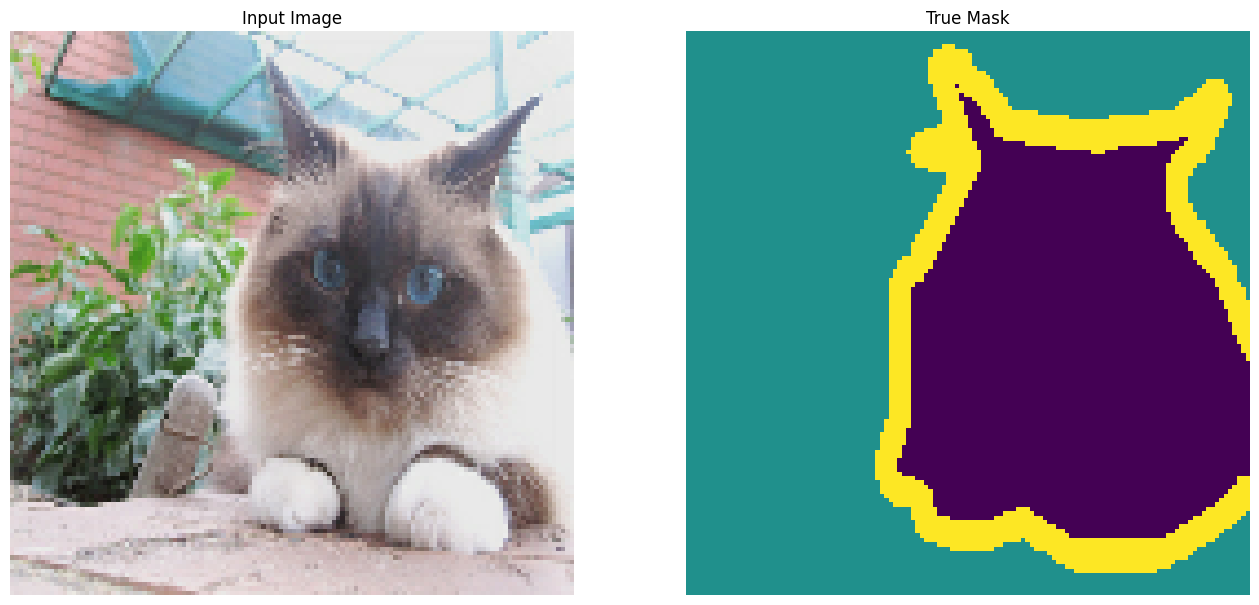

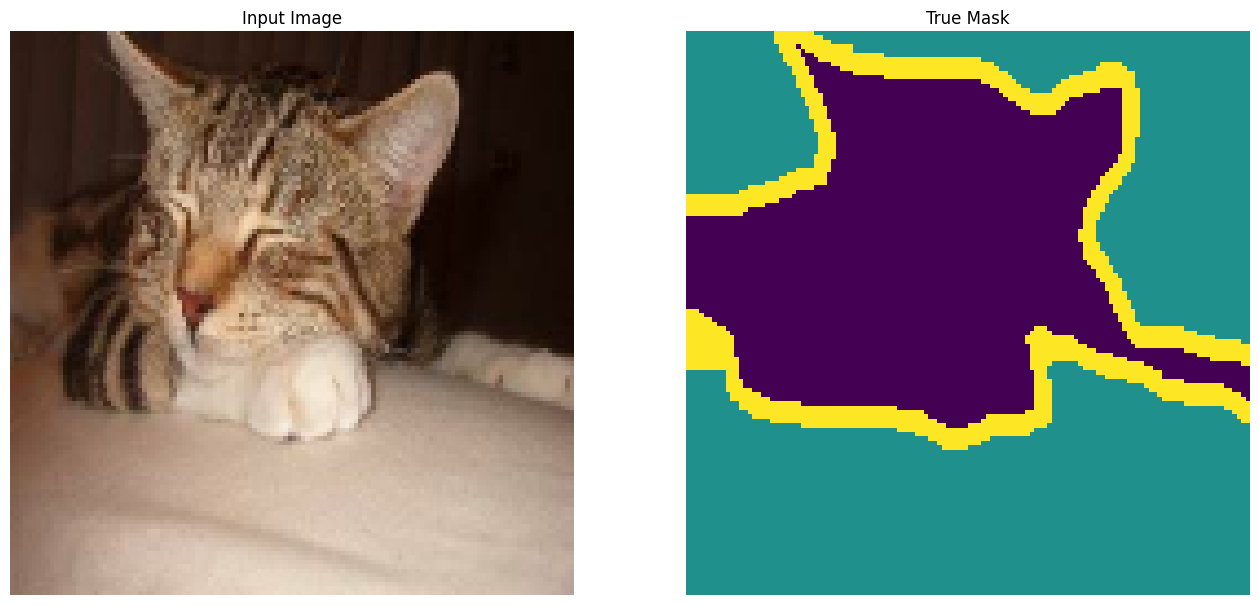

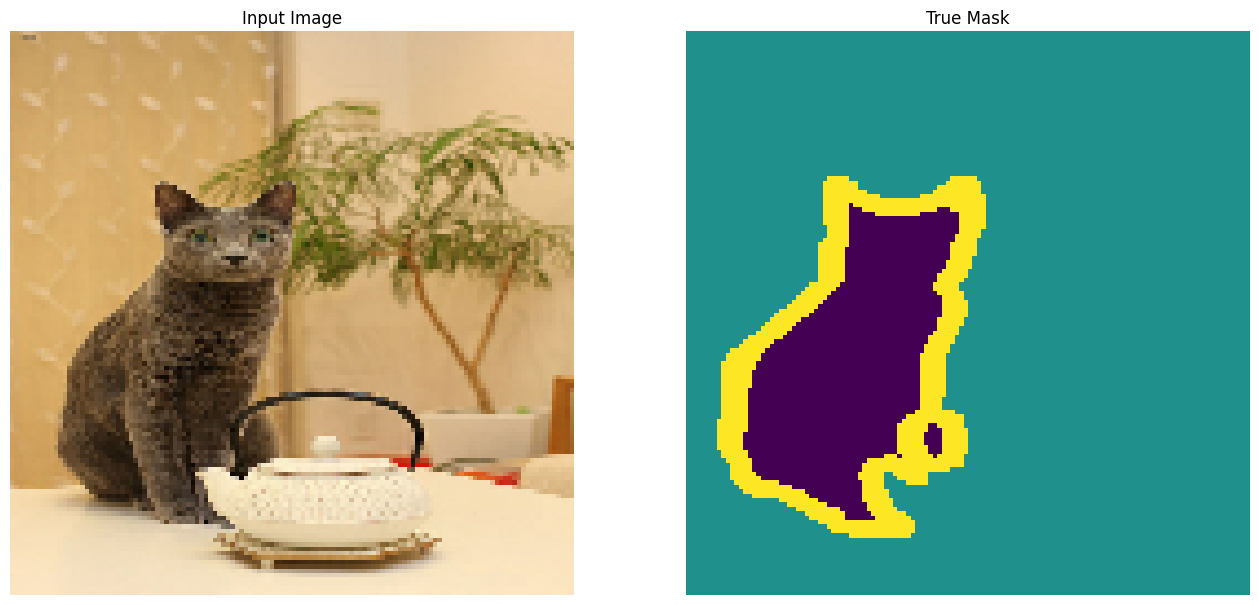

In [20]:
for images, masks in train_batches.take(3):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
#IMG_HEIGHT = 128
#IMG_WIDTH = 128
#IMG_CHANNELS = 3

In [ ]:

def get_model():
  inputs = Input((img_height, img_width, num_class))

  # Downsampling (encodere)
  sc1a = SeparableConv2D(filters=8,kernel_size=(3,1),padding='same')(inputs)
  c1a = Conv2D(filters=8, kernel_size=(1, 1), padding='same')(sc1a)
  sc1b = SeparableConv2D(filters=8,kernel_size=(1,3),padding='same')(c1a)
  c1b = Conv2D(filters=8, kernel_size=(1, 1), padding='same') (sc1b)
  db1 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c1b)
  bn1 = BatchNormalization()(db1)
  act1 = activations.relu(bn1)
  # reduce imge
  p1 = MaxPooling2D(pool_size=(2, 2))(act1)


  sc2a = SeparableConv2D(filters=16,kernel_size=(3,1),padding='same')(p1)
  c2a = Conv2D(filters=16, kernel_size=(1, 1), padding='same')(sc2a)
  sc2b = SeparableConv2D(filters=16,kernel_size=(1,3),padding='same')(c2a)
  c2b = Conv2D(filters=16, kernel_size=(1, 1), padding='same')(sc2b)
  db2 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c2b)
  bn2 = BatchNormalization()(db2)
  act2 = activations.relu(bn2)
  # reduce imge
  p2 = MaxPooling2D(pool_size=(2, 2))(act2)
  
  sc3a = SeparableConv2D(filters=32,kernel_size=(3,1),padding='same')(p2)
  c3a = Conv2D(filters=32, kernel_size=(1, 1), padding='same')(sc3a)
  sc3b = SeparableConv2D(filters=32,kernel_size=(1,3),padding='same')(c3a)
  c3b = Conv2D(filters=32, kernel_size=(1, 1), padding='same')(sc3b)
  db3 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c3b)
  bn3 = BatchNormalization()(db3)
  act3 = activations.relu(bn3)
  # reduce imge
  p3 = MaxPooling2D(pool_size=(2, 2))(act3)

  sc4a = SeparableConv2D(filters=64,kernel_size=(3,1),padding='same')(p3)
  c4a = Conv2D(filters=64, kernel_size=(1, 1), padding='same')(sc4a)
  sc4b = SeparableConv2D(filters=64,kernel_size=(1,3),padding='same')(c4a)
  c4b = Conv2D(filters=64, kernel_size=(1, 1), padding='same') (sc4b)
  db4 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c4b)
  bn4 = BatchNormalization()(db4)
  act4 = activations.relu(bn4)
  # reduce imge
  p4 = MaxPooling2D(pool_size=(2, 2))(act4)
  
  sc5a = SeparableConv2D(filters=128,kernel_size=(3,1),padding='same')(p4)
  c5a = Conv2D(filters=128, kernel_size=(1, 1), padding='same')(sc5a)
  sc5b = SeparableConv2D(filters=128,kernel_size=(1,3),padding='same')(c5a)
  c5b = Conv2D(filters=128, kernel_size=(1, 1), padding='same') (sc5b)
  db5 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c5b)
  bn5 = BatchNormalization()(db5)
  act5 = activations.relu(bn5)
  # reduce imge
  p5 = MaxPooling2D(pool_size=(2, 2))(act5)

  sc6a = SeparableConv2D(filters=256,kernel_size=(3,1),padding='same')(p5)
  c6a = Conv2D(filters=256, kernel_size=(1, 1), padding='same')(sc6a)
  sc6b = SeparableConv2D(filters=256,kernel_size=(1,3),padding='same')(c6a)
  c6b = Conv2D(filters=256, kernel_size=(1, 1), padding='same')(sc6b)
  db6 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c6b)
  bn6 = BatchNormalization()(db6)
  act6 = activations.relu(bn6)
  # reduce imge
  p6 = MaxPooling2D(pool_size=(2, 2))(act6)

  sc7a = SeparableConv2D(filters=512,kernel_size=(3,1),padding='same')(p6)
  c7a = Conv2D(filters=512, kernel_size=(1, 1), padding='same')(sc7a)
  sc7b = SeparableConv2D(filters=512,kernel_size=(1,3),padding='same')(c7a)
  c7b = Conv2D(filters=512, kernel_size=(1, 1), padding='same')(sc7b)
  db7 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c7b)
  bn7 = BatchNormalization()(db7)
  act7 = activations.relu(bn7)

  
  # upsampling (Decoder)
  ct8 = Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=(2, 2), padding='same')(act7)
  concat8 = Concatenate()([ct8, act6])
  sc8a = SeparableConv2D(filters=256,kernel_size=(3,1),padding='same')(concat8)
  c8a = Conv2D(filters=256, kernel_size=(1, 1), padding='same')(sc8a)
  sc8b = SeparableConv2D(filters=256,kernel_size=(1,3),padding='same')(c8a)
  c8b = Conv2D(filters=256, kernel_size=(1, 1), padding='same')(sc8b)
  db8 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c8b)
  bn8 = BatchNormalization()(db8)
  act8 = activations.relu(bn8)
  

  ct9 = Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same')(act8)
  concat9 = Concatenate()([ct9, act5])
  sc9a = SeparableConv2D(filters=128,kernel_size=(3,1),padding='same')(concat9)
  c9a = Conv2D(filters=128, kernel_size=(1, 1), padding='same')(sc9a)
  sc9b = SeparableConv2D(filters=128,kernel_size=(1,3),padding='same')(c9a)
  c9b = Conv2D(filters=128, kernel_size=(1, 1), padding='same')(sc9b)
  db9 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c9b)
  bn9 = BatchNormalization()(db9)
  act9 = activations.relu(bn9)

  ct10 = Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same')(act9)
  concat10 = Concatenate()([ct10, act4])
  sc10a = SeparableConv2D(filters=64,kernel_size=(3,1),padding='same')(concat10)
  c10a = Conv2D(filters=64, kernel_size=(1, 1), padding='same')(sc10a)
  sc10b = SeparableConv2D(filters=64,kernel_size=(1,3),padding='same')(c10a)
  c10b = Conv2D(filters=64, kernel_size=(1, 1), padding='same') (sc10b)
  db10 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c10b)
  bn10 = BatchNormalization()(db10)
  act10 = activations.relu(bn10)


  ct11 = Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), padding='same')(db10)
  concat11 = Concatenate()([ct11, act3])
  sc11a = SeparableConv2D(filters=32,kernel_size=(3,1),padding='same')(concat11)
  c11a = Conv2D(filters=32, kernel_size=(1, 1), padding='same')(sc11a)
  sc11b = SeparableConv2D(filters=32,kernel_size=(1,3),padding='same')(c11a)
  c11b = Conv2D(filters=32, kernel_size=(1, 1), padding='same')(sc11b)
  db11 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c11b)
  bn11 = BatchNormalization()(db11)
  act11 = activations.relu(bn11)


  ct12 = Conv2DTranspose(filters=16, kernel_size=(2, 2), strides=(2, 2), padding='same')(act11)
  concat12 = Concatenate()([ct12, act2])
  sc12a = SeparableConv2D(filters=16,kernel_size=(3,1),padding='same')(concat12)
  c12a = Conv2D(filters=16, kernel_size=(1, 1), padding='same')(sc12a)
  sc12b = SeparableConv2D(filters=16,kernel_size=(1,3),padding='same')(c12a)
  c12b = Conv2D(filters=16, kernel_size=(1, 1), padding='same') (sc12b)
  db12 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c12b)
  bn12 = BatchNormalization()(db12)
  act12 = activations.relu(bn12)


  ct13 = Conv2DTranspose(filters=8, kernel_size=(2, 2), strides=(2, 2), padding='same')(act12)
  concat13 = Concatenate()([ct13, act1])
  sc13a = SeparableConv2D(filters=8,kernel_size=(3,1),padding='same')(concat13)
  c13a = Conv2D(filters=8, kernel_size=(1, 1), padding='same')(sc13a)
  sc13b = SeparableConv2D(filters=8,kernel_size=(1,3),padding='same')(c13a)
  c13b = Conv2D(filters=8, kernel_size=(1, 1), padding='same')(sc13b)
  db13 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c13b)
  bn13 = BatchNormalization()(db13)
  act13 = activations.relu(bn13) 

  
  

  # Last / top layer
  outputs = Conv2D(filters=3, kernel_size=(1, 1),activation='tanh')(act13)
  

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [ ]:


def get_model2():
  inputs = Input((img_height, img_width, num_class))

  # Downsampling (encodere)
  c1a = Conv2D(filters=8,kernel_size=(3,3),padding='same',activation='elu')(inputs)
  c1b = Conv2D(filters=8, kernel_size=(3,3), padding='same',activation='elu')(c1a)
  db1 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c1b)
  bn1 = BatchNormalization()(db1)
  # reduce imge
  p1 = MaxPooling2D(pool_size=(2, 2))(bn1)


  c2a = Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='elu')(p1)
  c2b = Conv2D(filters=16, kernel_size=(3,3), padding='same',activation='elu')(c2a)
  db2 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c2b)
  bn2 = BatchNormalization()(db2)
  # reduce imge
  p2 = MaxPooling2D(pool_size=(2, 2))(bn2)
  
  c3a = Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='elu')(p2)
  c3b = Conv2D(filters=32, kernel_size=(3,3), padding='same',activation='elu')(c3a)
  db3 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c3b)
  bn3 = BatchNormalization()(db3)
  # reduce imge
  p3 = MaxPooling2D(pool_size=(2, 2))(bn3)

  c4a = Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='elu')(p3)
  c4b = Conv2D(filters=64, kernel_size=(3,3), padding='same',activation='elu')(c4a)
  db4 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c4b)
  bn4 = BatchNormalization()(db4)
  # reduce imge
  p4 = MaxPooling2D(pool_size=(2, 2))(bn4)
  
  c5a = Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='elu')(p4)
  c5b = Conv2D(filters=128, kernel_size=(3,3), padding='same',activation='elu')(c5a)
  db5 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c5b)
  bn5 = BatchNormalization()(db5)
  # reduce imge
  p5 = MaxPooling2D(pool_size=(2, 2))(bn5)

  c6a = Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='elu')(p5)
  c6b = Conv2D(filters=256, kernel_size=(3,3), padding='same',activation='elu')(c6a)
  db6 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c6b)
  bn6 = BatchNormalization()(db6)
  # reduce imge
  p6 = MaxPooling2D(pool_size=(2, 2))(bn6)

  c7a = Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='elu')(p6)
  c7b = Conv2D(filters=512, kernel_size=(3,3), padding='same',activation='elu')(c7a)
  db7 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c7b)
  bn7 = BatchNormalization()(db7)

  
  # upsampling (Decoder)
  ct8 = Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=(2, 2), padding='same')(bn7)
  concat8 = Concatenate()([ct8, bn6])
  c8a = Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='elu')(concat8)
  c8b = Conv2D(filters=256, kernel_size=(3,3), padding='same',activation='elu')(c8a)
  db8 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c8b)
  bn8 = BatchNormalization()(db8)
  

  ct9 = Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same')(bn8)
  concat9 = Concatenate()([ct9, bn5])
  c9a = Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='elu')(concat9)
  c9b = Conv2D(filters=128, kernel_size=(3,3), padding='same',activation='elu')(c9a)
  db9 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c9b)
  bn9 = BatchNormalization()(db9)

  ct10 = Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same')(bn9)
  concat10 = Concatenate()([ct10, bn4])
  c10a = Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='elu')(concat10)
  c10b = Conv2D(filters=64, kernel_size=(3,3), padding='same',activation='elu')(c10a)
  db10 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c10b)
  bn10 = BatchNormalization()(db10)


  ct11 = Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), padding='same')(bn10)
  concat11 = Concatenate()([ct11, bn3])
  c11a = Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='elu')(concat11)
  c11b = Conv2D(filters=32, kernel_size=(3,3), padding='same',activation='elu')(c11a)
  db11 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c11b)
  bn11 = BatchNormalization()(db11)


  ct12 = Conv2DTranspose(filters=16, kernel_size=(2, 2), strides=(2, 2), padding='same')(bn11)
  concat12 = Concatenate()([ct12, bn2])
  c12a = Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='elu')(concat12)
  c12b = Conv2D(filters=16, kernel_size=(3,3), padding='same',activation='elu')(c12a)
  db12 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c12b)
  bn12 = BatchNormalization()(db12)


  ct13 = Conv2DTranspose(filters=8, kernel_size=(2, 2), strides=(2, 2), padding='same')(bn12)
  concat13 = Concatenate()([ct13, bn1])
  c13a = Conv2D(filters=8,kernel_size=(3,3),padding='same',activation='elu')(concat13)
  c13b = Conv2D(filters=8, kernel_size=(3,3), padding='same',activation='elu')(c13a)
  db13 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c13b)
  bn13 = BatchNormalization()(db13)

  
  

  # Last / top layer
  outputs = Conv2D(filters=3, kernel_size=(1, 1),activation='tanh')(bn13)
  

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [ ]:


def get_model3():
  inputs = Input((img_height, img_width, num_class))

  # Downsampling (encodere)
  c1a = Conv2D(filters=8,kernel_size=(3,3),padding='same',activation='elu')(inputs)
  db1 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c1a)
  c1b = Conv2D(filters=8, kernel_size=(3,3), padding='same',activation='elu')(db1)
  bn1 = BatchNormalization()(c1b)
  # reduce imge
  p1 = MaxPooling2D(pool_size=(2, 2))(bn1)


  c2a = Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='elu')(p1)
  db2 = DropBlock2D(rate=0.1,block_size=int(img_height/4))(c2a)
  c2b = Conv2D(filters=16, kernel_size=(3,3), padding='same',activation='elu')(db2)
  bn2 = BatchNormalization()(c2b)
  # reduce imge
  p2 = MaxPooling2D(pool_size=(2, 2))(bn2)
  
  c3a = Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='elu')(p2)
  db3 = DropBlock2D(rate=0.15,block_size=int(img_height/8))(c3a)
  c3b = Conv2D(filters=32, kernel_size=(3,3), padding='same',activation='elu')(db3)
  bn3 = BatchNormalization()(c3b)
  # reduce imge
  p3 = MaxPooling2D(pool_size=(2, 2))(bn3)

  c4a = Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='elu')(p3)
  db4 = DropBlock2D(rate=0.2,block_size=int(img_height/16))(c4a)
  c4b = Conv2D(filters=64, kernel_size=(3,3), padding='same',activation='elu')(db4)
  bn4 = BatchNormalization()(c4b)
  # reduce imge
  p4 = MaxPooling2D(pool_size=(2, 2))(bn4)
  
  c5a = Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='elu')(p4)
  db5 = DropBlock2D(rate=0.25,block_size=int(img_height/32))(c5a)
  c5b = Conv2D(filters=128, kernel_size=(3,3), padding='same',activation='elu')(db5)
  bn5 = BatchNormalization()(c5b)
  # reduce imge
  p5 = MaxPooling2D(pool_size=(2, 2))(bn5)

  c6a = Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='elu')(p5)
  db6 = DropBlock2D(rate=0.25,block_size=int(img_height/32))(c6a)
  c6b = Conv2D(filters=256, kernel_size=(3,3), padding='same',activation='elu')(db6)
  bn6 = BatchNormalization()(c6b)
  
  
  # upsampling (Decoder)
  ct7 = Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=(2, 2), padding='same')(bn6)
  concat7 = Concatenate()([ct7, bn5])
  c7a = Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='elu')(concat7)
  db7 = DropBlock2D(rate=0.25,block_size=int(img_height/32))(c7a)
  c7b = Conv2D(filters=256, kernel_size=(3,3), padding='same',activation='elu')(db7)
  bn7 = BatchNormalization()(c7b)
  

  ct8 = Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same')(bn7)
  concat8 = Concatenate()([ct8, bn4])
  c8a = Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='elu')(concat8)
  db8 = DropBlock2D(rate=0.2,block_size=int(img_height/16))(c8a)
  c8b = Conv2D(filters=128, kernel_size=(3,3), padding='same',activation='elu')(db8)
  bn8 = BatchNormalization()(c8b)

  ct9 = Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same')(bn8)
  concat9 = Concatenate()([ct9, bn3])
  c9a = Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='elu')(concat9)
  db9 = DropBlock2D(rate=0.15,block_size=int(img_height/8))(c9a)
  c9b = Conv2D(filters=64, kernel_size=(3,3), padding='same',activation='elu')(db9) 
  bn9 = BatchNormalization()(c9b)


  ct10 = Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), padding='same')(bn9)
  concat10 = Concatenate()([ct10, bn2])
  c10a = Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='elu')(concat10)
  db10 = DropBlock2D(rate=0.1,block_size=int(img_height/4))(c10a)
  c10b = Conv2D(filters=32, kernel_size=(3,3), padding='same',activation='elu')(db10)
  bn10 = BatchNormalization()(c10b)


  ct11 = Conv2DTranspose(filters=16, kernel_size=(2, 2), strides=(2, 2), padding='same')(bn10)
  concat11 = Concatenate()([ct11, bn1])
  c11a = Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='elu')(concat11)
  db11 = DropBlock2D(rate=0.05,block_size=int(img_height/2))(c11a)
  c11b = Conv2D(filters=16, kernel_size=(3,3), padding='same',activation='elu')(db11)
  bn11 = BatchNormalization()(c11b)


  # Last / top layer
  outputs = Conv2D(filters=3, kernel_size=(1, 1),activation='tanh')(bn11)
  

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [ ]:
unet_model = get_model3()

In [ ]:
lr = 0.001

#
unet_model.compile(optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',
                       tf.keras.metrics.MeanIoU(num_classes=3,
                                                  sparse_y_pred = False)])

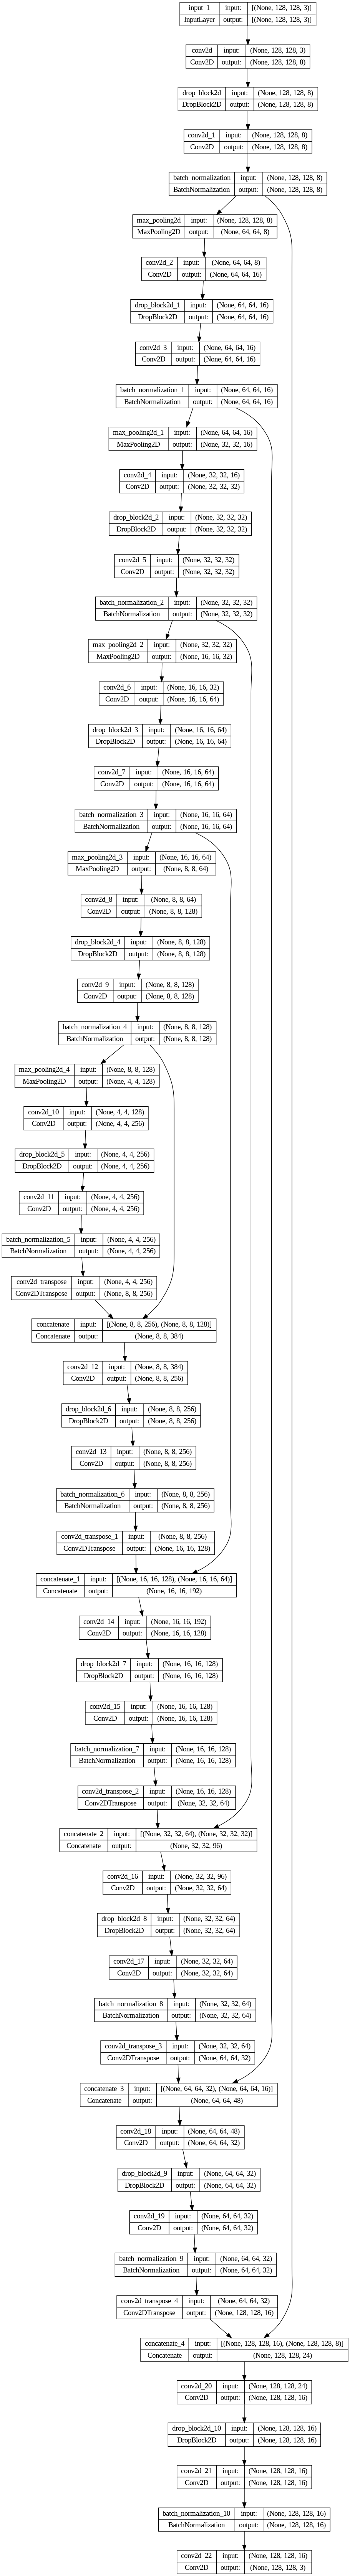

In [ ]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [ ]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  224         ['input_1[0][0]']                
                                                                                                  
 drop_block2d (DropBlock2D)     (None, 128, 128, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 8)  584         ['drop_block2d[0][0]']       

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]

  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 10s 10s/step


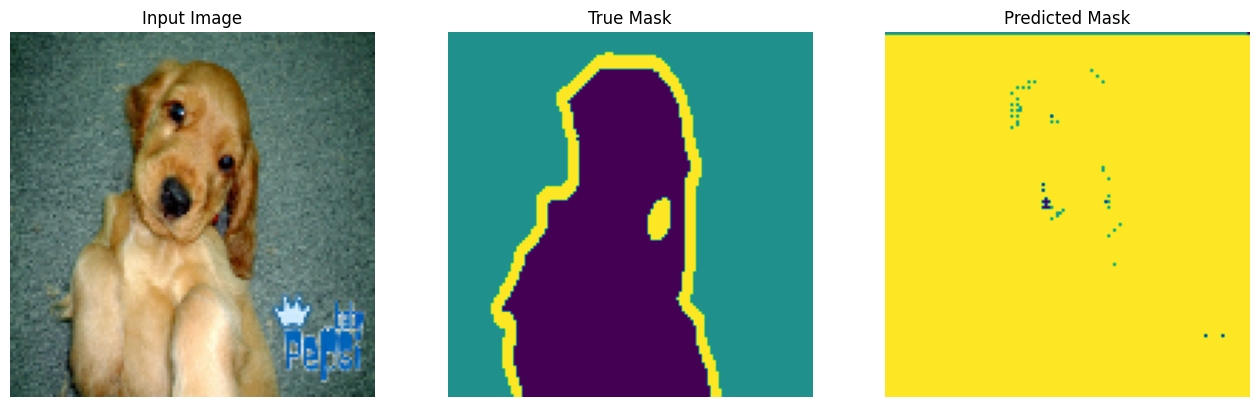

In [ ]:
# show model predictions before training
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
filepath = "unet_model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

callbacks_list = [earlystopper,checkpoint,reduce_lr,DisplayCallback()]

1/1 [==============================] - 0s 26ms/step


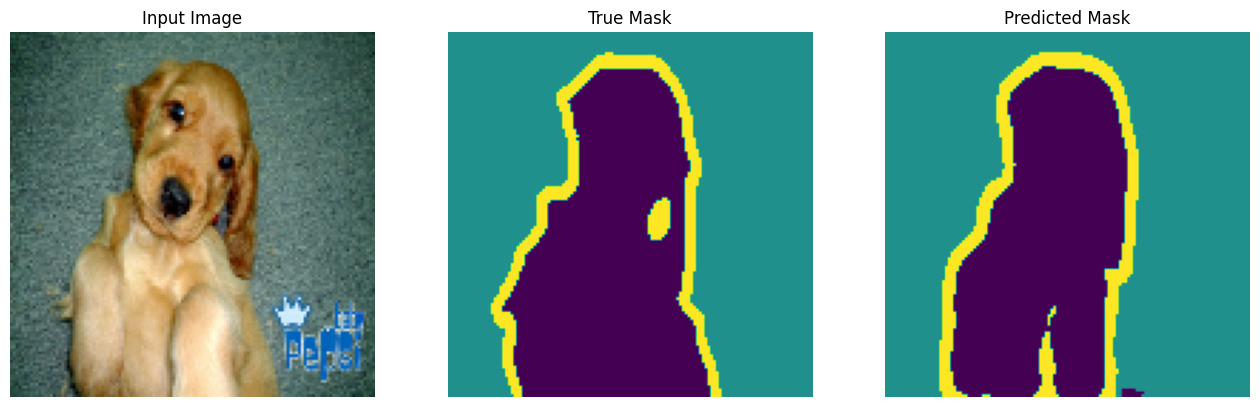


Sample Prediction after epoch 27

196/196 [==============================] - 45s 229ms/step - loss: 0.4025 - accuracy: 0.9025 - mean_io_u: 0.7326 - val_loss: 0.4399 - val_accuracy: 0.8832 - val_mean_io_u: 0.7061 - lr: 0.0010
Epoch 27: early stopping


In [ ]:
EPOCHS = 75


model_history = unet_model.fit(train_batches, epochs=EPOCHS,
                          validation_data=test_batches,
                          callbacks=callbacks_list)

In [ ]:
var = list(model_history.history.keys())
var

['loss',
 'accuracy',
 'mean_io_u',
 'val_loss',
 'val_accuracy',
 'val_mean_io_u',
 'lr']

In [ ]:
def show_history(model_history):
  
  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']

  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  mean_iou = model_history.history[var[2]]
  val_mean_iou = model_history.history[var[5]]
  

  epochs_range = model_history.epoch

  plt.figure(figsize=(14, 6))

  plt.subplot(1,3,1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')

  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')


  plt.subplot(1, 3, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')

  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')


  plt.subplot(1, 3, 3)
  plt.plot(epochs_range, mean_iou, label='Training Mean_IoU')
  plt.plot(epochs_range, val_mean_iou, label='Validation Mean_IoU')

  plt.legend(loc='lower right')
  plt.title('Training and Validation Mean IoU')
  plt.show()

  train_acc = model_history.history['accuracy'][-1]
  val_acc = model_history.history['val_accuracy'][-1]
  train_loss = model_history.history['loss'][-1]
  val_loss = model_history.history['val_loss'][-1]
  train_meanIoU = model_history.history[var[2]][-1]
  val_meanIoU = model_history.history[var[5]][-1]

  print(f'Training accuracy: {train_acc:.3f}\tTraining loss: {train_loss:.3f}\tTraining Mean IoU: {train_meanIoU:.3f}')
  print(f'Validation accuracy: {val_acc:.3f}\tValidation loss: {val_loss:.3f}\tValidation Mean IoU: {val_meanIoU:.3f}')
  


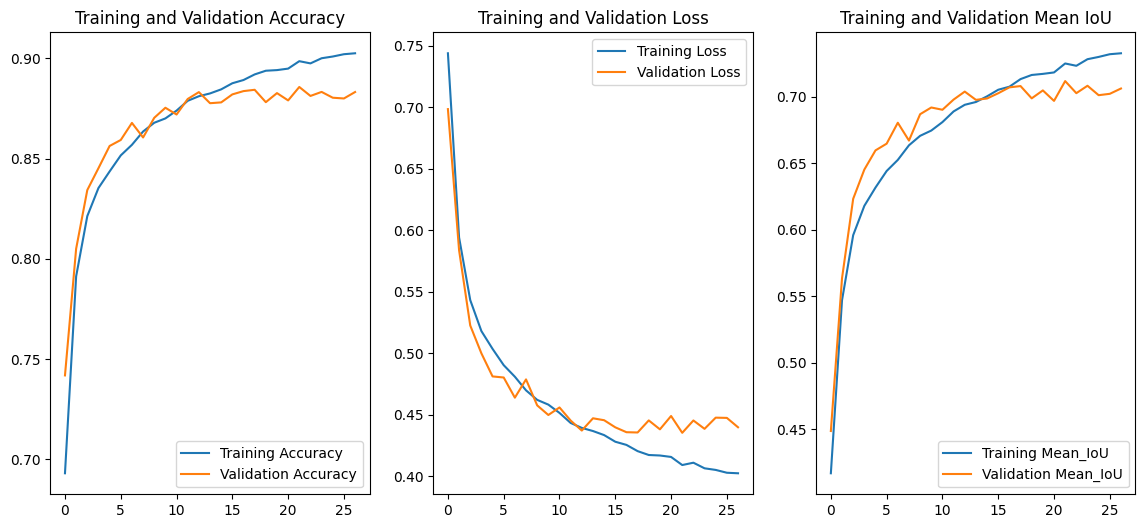

Training accuracy: 0.902	Training loss: 0.403	Training Mean IoU: 0.733
Validation accuracy: 0.883	Validation loss: 0.440	Validation Mean IoU: 0.706


In [ ]:
show_history(model_history)

In [ ]:
test_loss,test_accuracy,test_meaniou =  unet_model.evaluate(test_batches)

12/12 [==============================] - 0s 31ms/step - loss: 0.4399 - accuracy: 0.8832 - mean_io_u: 0.7061


In [ ]:
print(f'Test loss: {test_loss}\nTest accuracy: {test_accuracy}\nTest MeanIoU: {test_meaniou}')

Test loss: 0.4399188756942749
Test accuracy: 0.883161723613739
Test MeanIoU: 0.7060820460319519
